# NYC taxi example using One-Class SVM

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import svm
import sklearn.metrics as met

import rrcf
from rrcf.shingle import shingle

In [ ]:
def metrics(labels, y_pred, name, sample):
    print(name,sample)
    print(met.precision_score(labels, y_pred))
    print(met.classification_report(labels, y_pred))

## Load and shingle data

In [2]:
data = np.load("taxi_all.npz")
data_passengers = data["passengers"]

data_dim = 48

data_stream = shingle(data_passengers, data_dim)
data_passengers_shingle = np.asarray(next(data_stream))
for i in range(1,len(data_passengers)-data_dim+1):
    data_passengers_shingle = np.vstack((data_passengers_shingle, next(data_stream)))

In [3]:
# Anamolies from the paper
labels = np.load('labels.npy')
labels = labels.astype(int)
# Labels anomalies as 1; otherwise 0
labels[labels == 1] = 0
labels[labels == -1] = 1

## Establish and run OC-SVM algorithm via scikit-learn

In [4]:
outliers_fraction = len(labels[labels==1])/len(labels)
algorithm = svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)

In [5]:
np.random.seed(0)
nIters = 100

def runOCSVM(data,data_shingle,sample_size,algorithm):
    for j in range(0,nIters):
        sample = np.random.choice(len(data_shingle),sample_size)
        algorithm.fit(data_shingle[sample,:])
    y_pred = algorithm.fit(data_shingle[sample,:]).predict(data_shingle)
    # Labels are assigned 1 if anomaly; else, label as 0
    y_pred[y_pred == -1] = 0
    
    # Compute performance metrics
    tn, fp, fn, tp = met.confusion_matrix(labels[data_dim-1:], y_pred).ravel()
    ppv = tp /(tp + fp)
    precall = tp /(tp + fn)
    
    npv = tn /(tn + fn)
    nrecall = tn /(tn + fp)
    
    acc = (tp + tn) / (tp+tn+fp+fn)
    
    print('IF, Sample size: ' + str(sample_size))
    print("Positive Precision:", ppv)
    print("Positive Recall   :", precall)
    print("Negative Precision:", npv)
    print("Negative Recall   :", nrecall)
    print("Accuracy          :", acc)
    print()
    
    # Color detected anomalies in red
    colors = np.array(['#000000', '#ff0000'])
    plt.scatter(np.linspace(0,len(data)-1,len(data)),data, s=10, color=colors[y_pred.astype(int)])
    plt.show()
    
    return y_pred

IF, Sample size: 256
Positive Precision: 0.0535714285714
Positive Recall   : 0.00568181818182
Negative Precision: 0.948615053342
Negative Recall   : 0.994561313494
Accuracy          : 0.943736007009



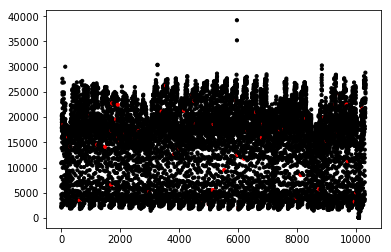

In [7]:
y_pred = runOCSVM(data_passengers,data_passengers_shingle,256,algorithm)

IF, Sample size: 512
Positive Precision: 0.0727272727273
Positive Recall   : 0.0227272727273
Negative Precision: 0.948951325683
Negative Recall   : 0.984299640841
Accuracy          : 0.934877835102



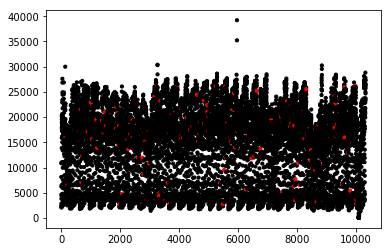

In [8]:
y_pred = runOCSVM(data_passengers,data_passengers_shingle,512,algorithm)

IF, Sample size: 1024
Positive Precision: 0.0571120689655
Positive Recall   : 0.100378787879
Negative Precision: 0.949170679508
Negative Recall   : 0.910210364289
Accuracy          : 0.868587559622



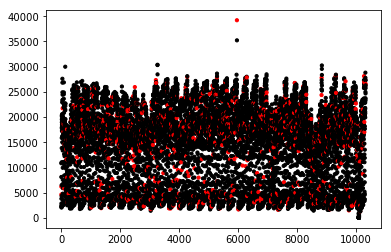

In [9]:
y_pred = runOCSVM(data_passengers,data_passengers_shingle,1024,algorithm)